In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import math
import nnfs
from  nnfs.datasets import vertical_data
nnfs.init()
import numpy as np
import matplotlib.pyplot as plt



In [2]:
def spiral_data(points, classes):
    X = np.zeros((points*classes, 2))
    y = np.zeros(points*classes, dtype='uint8')
    for class_number in range(classes):
        ix = range(points*class_number, points*(class_number+1))
        r = np.linspace(0.0, 1, points)  # radius
        t = np.linspace(class_number*4, (class_number+1)*4, points) + np.random.randn(points)*0.2
        X[ix] = np.c_[r*np.sin(t*2.5), r*np.cos(t*2.5)]
        y[ix] = class_number
    return X, y

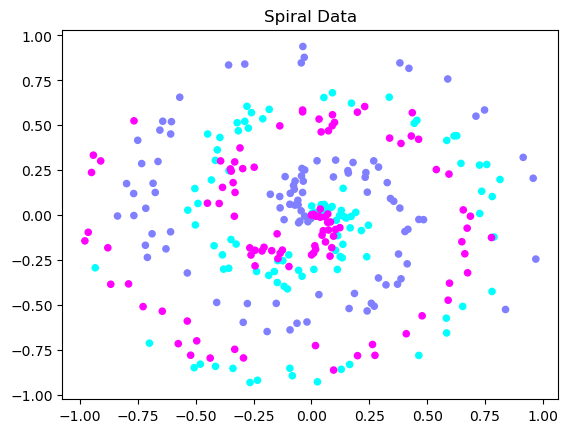

In [3]:
import numpy as np
import matplotlib.pyplot as plt

X, y = spiral_data(points=100, classes=3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="cool", s=20)
plt.title("Spiral Data")
plt.show()


In [4]:

np.random.seed(0)

class Layer_Dense:
    def __init__(self,n_inputs,n_neurons):
        self.weights=0.01*np.random.randn(n_inputs,n_neurons)
        self.biases = np.zeros((1,n_neurons))
        
    def forward(self,inputs):
        self.inputs=inputs
        self.output=np.dot(inputs,self.weights)+self.biases
        
        
        
    def backward(self,dvalues) :
        
        self.dweights =np.dot(self.inputs.T,dvalues ) 
        self.dbiases =np.sum(dvalues,axis=0,keepdims=True) 
        self.dinputs=np.dot(dvalues,self.weights.T)
        
             
        
    
    


class Activation_ReLU:
    def forward(self,inputs):
        self.inputs = inputs
        self.output=np.maximum(0,inputs)           
    
    
    def backward(self,dvalues):
        
        self.dinputs = dvalues.copy()
        
        # derivative of the ReLU 1(x > 0)
        self.dinputs[self.inputs<=0]=0   



       
class Activation_Softmax:
    
    # for forward propogation      
    def forward(self,inputs):
        exp_values=np.exp(inputs -np.max(inputs,axis=1,keepdims=True))
        probabilities = exp_values/np.sum(exp_values,axis=1,keepdims=True)
        self.outputs=probabilities
                       



                     
class Loss:
    def calculate(self ,output,y):
        sample_losses=self.forward(output,y)
        data_loss=np.mean(sample_losses)
        return data_loss





class Loss_CategoricalCrossentropy(Loss):
    
    
    def forward(self,y_pred,y_true):
        samples= len(y_pred)
        y_pred_clipped=np.clip(y_pred,1e-7,1-1e-7)
        
        
        if len(y_true.shape)==1:
            correct_confidences =y_pred_clipped[range(samples),y_true]
         
        elif len(y_true.shape)==2:
            correct_confidences=np.sum(y_pred_clipped*y_true,axis=1)
            
            
        negative_log_likelihoods =-np.log(correct_confidences)
        return negative_log_likelihoods

    
    def backward(self,dvalues,y_true):
        
        samples = len(dvalues)
        labels= len(dvalues[0])
        
        if len(y_true.shape)==1 :
            y_true = np.eye(labels)[y_true]

        
        
        self.dinputs=-y_true/dvalues
        # Normalization of the batch 
        self.dinputs=self.dinputs/samples    


           
class Accuracy:
    def calculate(self,outputs,y_true):
        prediction = np.argmax(outputs,axis=1)
        
        if len(y_true.shape)== 2:
            y_true = np.argmax(y_true,axis=1)
            
        accuracy = np.mean(prediction==y_true)
        
        return accuracy





class Activation_Softmax_Loss_CategoricalCrossentropy():
    
    
    def __init__(self):
        self.activation=Activation_Softmax()
        self.loss=Loss_CategoricalCrossentropy()
    
    
       
    def forward (self,inputs,y_true):
        self.activation.forward(inputs)
        self.output=self.activation.outputs
        
        
        return self.loss.calculate(self.output,y_true)           

    
    def backward(self,dvalues,y_true):
        
        sample =len(dvalues)
        
        
        if len(y_true.shape) ==2 :
            
            y_true = np.argmax(y_true,axis=1)
         
        # caluculation of  
        self.dinputs = dvalues.copy()
        
        # most important line of code / 
        self.dinputs[range(sample),y_true]-=1
        
        # normalization of gradient 

        self.dinputs = self.dinputs/sample 
        

class Optimizer_SGD:
    
    def __init__(self,learning_rate=0.1):
        self.learning_rate =learning_rate
    
    def update_params(self,layer):
        layer.weights += -self.learning_rate * layer.dweights 
        layer.biases += -self.learning_rate * layer.dbiases             

In [5]:
dense_1=Layer_Dense(2,64)
Activation_ReLU_1=Activation_ReLU()
dense_2=Layer_Dense(64,3)
loss_combine_crossentropy_1=Activation_Softmax_Loss_CategoricalCrossentropy()
optimizer=Optimizer_SGD()


a=[]
l=[]

for epoch in range(1000000):
    
    dense_1.forward(X)
    
    Activation_ReLU_1.forward(dense_1.output)
    
    dense_2.forward(Activation_ReLU_1.output)
    
    loss=loss_combine_crossentropy_1.forward(dense_2.output,y)
    
    
    predictions = np.argmax(loss_combine_crossentropy_1.output, axis=1) 
    if len(y.shape) == 2: 
        y = np.argmax(y, axis=1) 
    accuracy = np.mean(predictions==y) 
    
    a.append(accuracy)
    l.append(loss)
    if not epoch % 100: 
        print(f'epoch: {epoch}, ' + 
              f'acc: {accuracy:.3f}, ' + 
              f'loss: {loss:.3f}') 
    
    loss_combine_crossentropy_1.backward(loss_combine_crossentropy_1.output,y)
    dense_2.backward(loss_combine_crossentropy_1.dinputs)
    Activation_ReLU_1.backward(dense_2.dinputs)
    dense_1.backward(Activation_ReLU_1.dinputs)
    
    
    optimizer.update_params(dense_1)
    optimizer.update_params(dense_2)
    

epoch: 0, acc: 0.377, loss: 1.099
epoch: 100, acc: 0.433, loss: 1.098
epoch: 200, acc: 0.423, loss: 1.098
epoch: 300, acc: 0.423, loss: 1.098
epoch: 400, acc: 0.430, loss: 1.098
epoch: 500, acc: 0.427, loss: 1.097
epoch: 600, acc: 0.423, loss: 1.096
epoch: 700, acc: 0.420, loss: 1.095
epoch: 800, acc: 0.417, loss: 1.093
epoch: 900, acc: 0.413, loss: 1.091
epoch: 1000, acc: 0.420, loss: 1.088
epoch: 1100, acc: 0.417, loss: 1.086
epoch: 1200, acc: 0.417, loss: 1.083
epoch: 1300, acc: 0.420, loss: 1.082
epoch: 1400, acc: 0.417, loss: 1.081
epoch: 1500, acc: 0.420, loss: 1.080
epoch: 1600, acc: 0.427, loss: 1.079
epoch: 1700, acc: 0.427, loss: 1.079
epoch: 1800, acc: 0.433, loss: 1.078
epoch: 1900, acc: 0.433, loss: 1.078
epoch: 2000, acc: 0.440, loss: 1.078
epoch: 2100, acc: 0.447, loss: 1.077
epoch: 2200, acc: 0.427, loss: 1.077
epoch: 2300, acc: 0.420, loss: 1.077
epoch: 2400, acc: 0.420, loss: 1.077
epoch: 2500, acc: 0.417, loss: 1.077
epoch: 2600, acc: 0.417, loss: 1.077
epoch: 2700, 

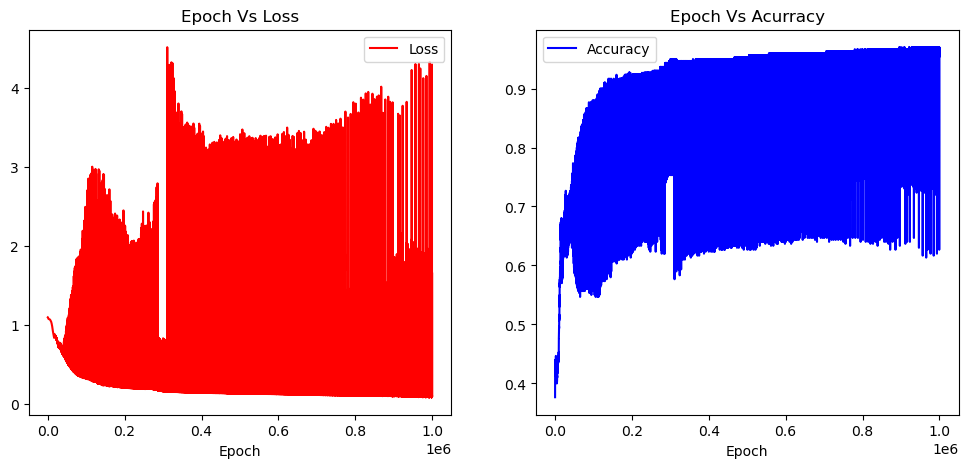

In [6]:
loss_history = l
accuracy_history = a

fig, axs = plt.subplots(1, 2, figsize=(12, 5))



axs[0].plot(loss_history, label="Loss", color="red")
axs[0].set_xlabel("Epoch")
axs[0].set_title("Epoch Vs Loss")
axs[0].legend()




axs[1].plot(accuracy_history, label="Accuracy", color="blue")
axs[1].set_xlabel("Epoch")
axs[1].set_title("Epoch Vs Acurracy")
axs[1].legend()





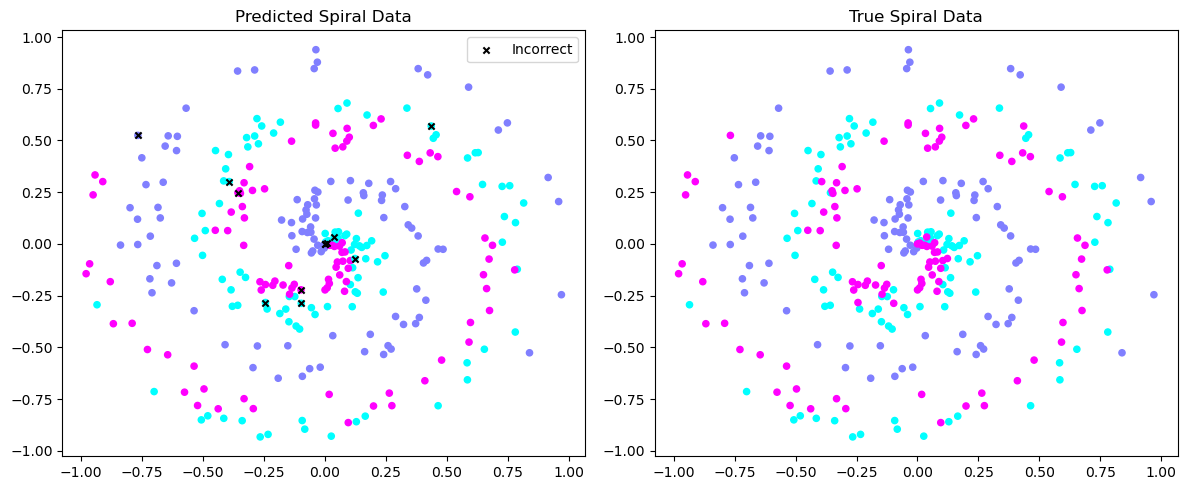

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

correct = predictions == y
incorrect = predictions != y

axs[0].scatter(X[:, 0], X[:, 1], c=predictions, cmap="cool",s=20)

# Incorrectly predicted points (in black)
axs[0].scatter(X[incorrect, 0], X[incorrect, 1], c='black', marker='x', s=20, label="Incorrect")

axs[0].set_title("Predicted Spiral Data")
axs[0].legend()

# True labels
axs[1].scatter(X[:, 0], X[:, 1], c=y, cmap="cool", s=20)
axs[1].set_title("True Spiral Data")

plt.tight_layout()
plt.show()
